<a href="https://colab.research.google.com/github/htnphu/retail-demand-forecasting/blob/main/m5_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8')

import gc

import logging
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Fall_2025/CPSC_5305_Intro_to_DS/data/"

In [ ]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype

        # --- FIX: Skip Datetime Columns ---
        if pd.api.types.is_datetime64_any_dtype(col_type):
            continue
        # -----------------------------------

        # Only process numeric columns for min/max
        if col_type != object and not isinstance(col_type, pd.CategoricalDtype):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # This is where the error occurred previously for datetime types
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # Handle categorical columns without min/max
        elif isinstance(col_type, pd.CategoricalDtype):
            df[col] = df[col].cat.as_unordered()  # Ensure no ordering assumption
        else:
            df[col] = df[col].astype('category')  # Convert objects to category
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Memory usage decreased from {start_mem:.2f} Mb to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

In [ ]:
print("Loading and reducing memory usage for data files...")
df = pd.read_parquet(f'{DATA_PATH}m5_processed.parquet')
df = reduce_mem_usage(df)
print("\nInitial data loading complete.")

Loading and reducing memory usage for data files...
Memory usage decreased from 2484.67 Mb to 2146.11 Mb (13.6% reduction)

Initial data loading complete.


In [ ]:
gc.collect()

101

In [ ]:
print(df.head().to_markdown())

|    | id                          | item_id     | dept_id   | cat_id   | store_id   | state_id   | d   |   sales |   wm_yr_wk |   sell_price | date                | weekday   |   wday |   month |   year |   snap_CA |   snap_TX |   snap_WI | event_name_1   | event_type_1   | event_name_2   | event_type_2   |
|---:|:----------------------------|:------------|:----------|:---------|:-----------|:-----------|:----|--------:|-----------:|-------------:|:--------------------|:----------|-------:|--------:|-------:|----------:|----------:|----------:|:---------------|:---------------|:---------------|:---------------|
|  0 | FOODS_1_001_CA_1_evaluation | FOODS_1_001 | FOODS_1   | FOODS    | CA_1       | CA         | d_1 |       3 |      11101 |            2 | 2011-01-29 00:00:00 | Saturday  |      1 |       1 |   2011 |         0 |         0 |         0 | No event       | No event       | No event       | No event       |
|  1 | FOODS_1_001_CA_1_evaluation | FOODS_1_001 | FOODS_1   | FOODS  

## EDA

Percentage of days with zero sales: 68.00%


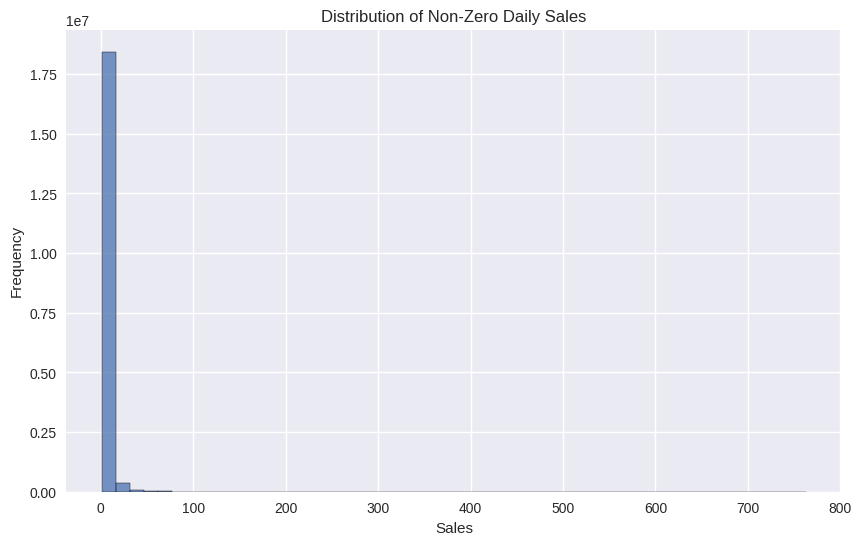

In [ ]:
# zero-sales percentage
zero_sales_pct = (df['sales'] == 0).mean() * 100
print(f'Percentage of days with zero sales: {zero_sales_pct:.2f}%')

# histogram of sales (excluding zeros for better visibility of non-zero sales)
plt.figure(figsize=(10, 6))
sns.histplot(df[df['sales'] > 0]['sales'], bins=50)
plt.title('Distribution of Non-Zero Daily Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

del zero_sales_pct

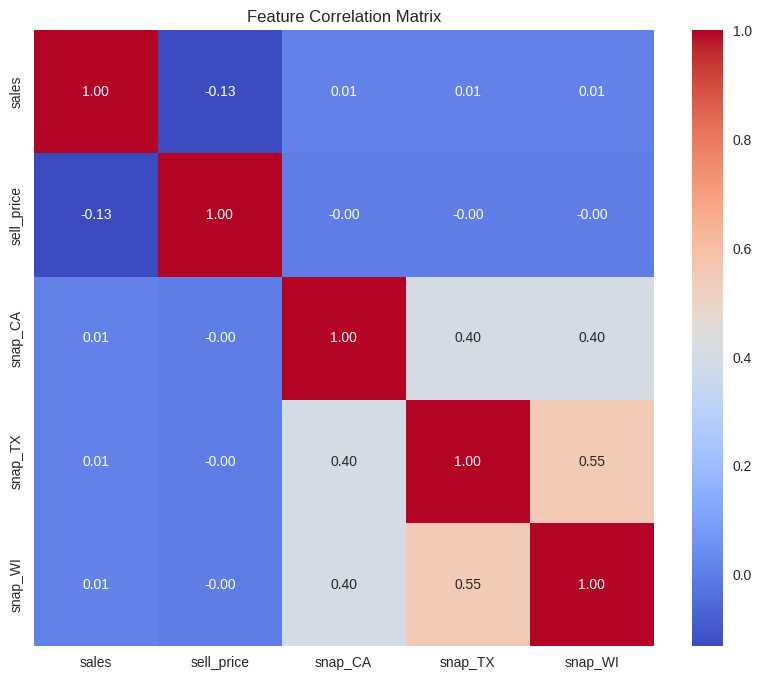

In [ ]:
# relevant columns for correlation
corr_cols = ['sales', 'sell_price', 'snap_CA', 'snap_TX', 'snap_WI']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

del corr_cols, corr_matrix

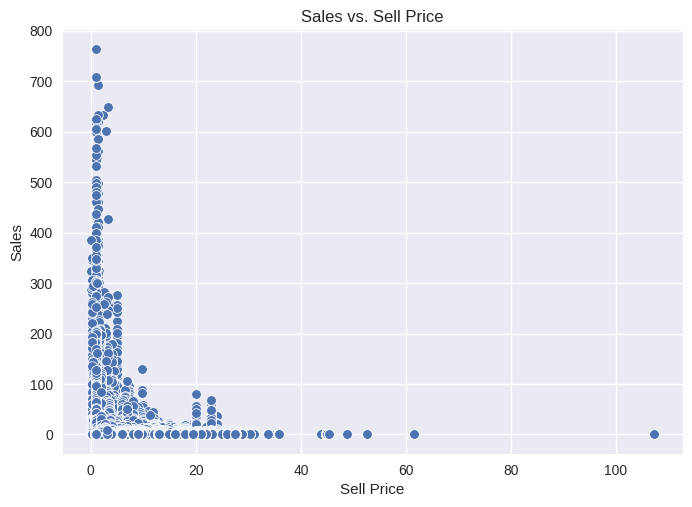

In [ ]:
sns.scatterplot(data=df, x='sell_price', y='sales')
plt.title('Sales vs. Sell Price')
plt.xlabel('Sell Price')
plt.ylabel('Sales')

plt.show()

In [ ]:
gc.collect()

12256

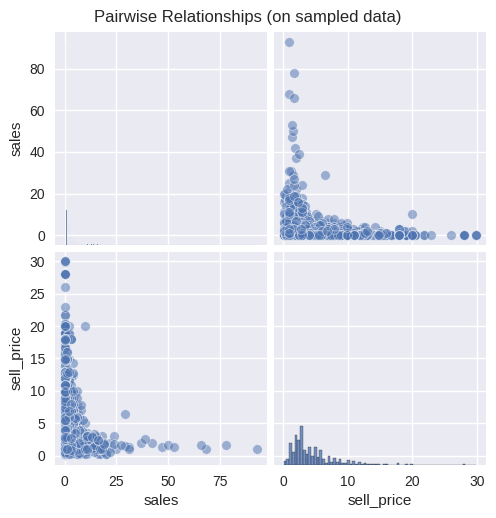

In [ ]:
# take a sample
df_sample = df.sample(n=5000, random_state=42)

# pairwise relationships
sns.pairplot(df_sample[['sales', 'sell_price']],
             plot_kws={'alpha': 0.5})
plt.suptitle('Pairwise Relationships (on sampled data)', y=1.02)
plt.show()

del df_sample

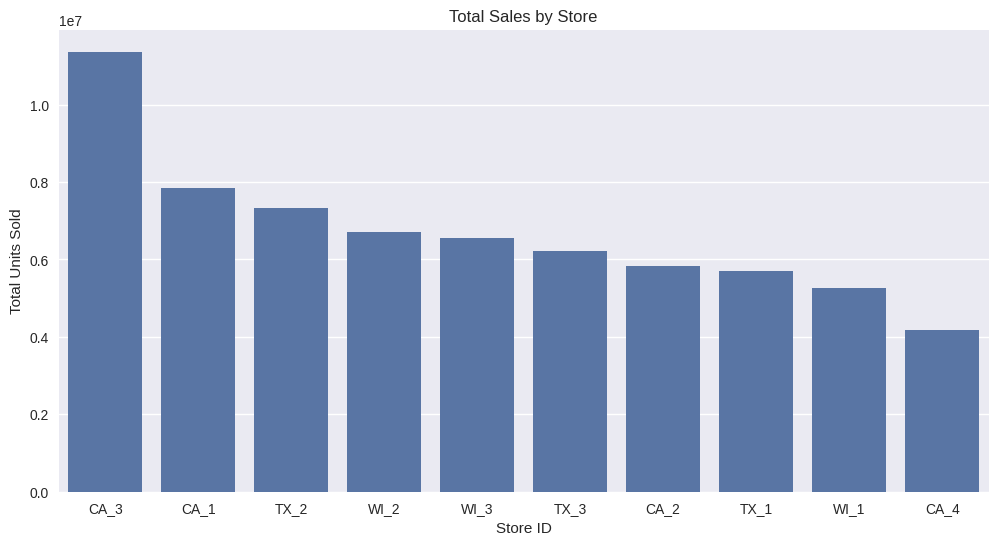

In [ ]:
# aggregate sales by store
store_sales = df.groupby('store_id')['sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='store_id', y='sales', data=store_sales, order=store_sales.sort_values('sales', ascending=False)['store_id'])
plt.title('Total Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Total Units Sold')
plt.show()

del store_sales

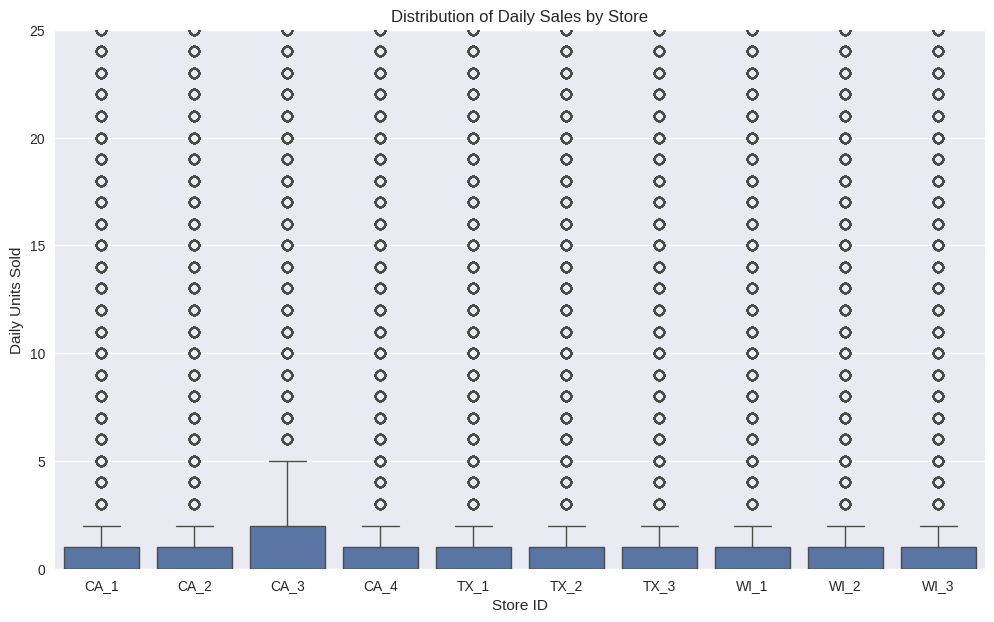

128

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='store_id', y='sales', data=df)
plt.ylim(0, 25)
plt.title('Distribution of Daily Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Daily Units Sold')
plt.show()

gc.collect()

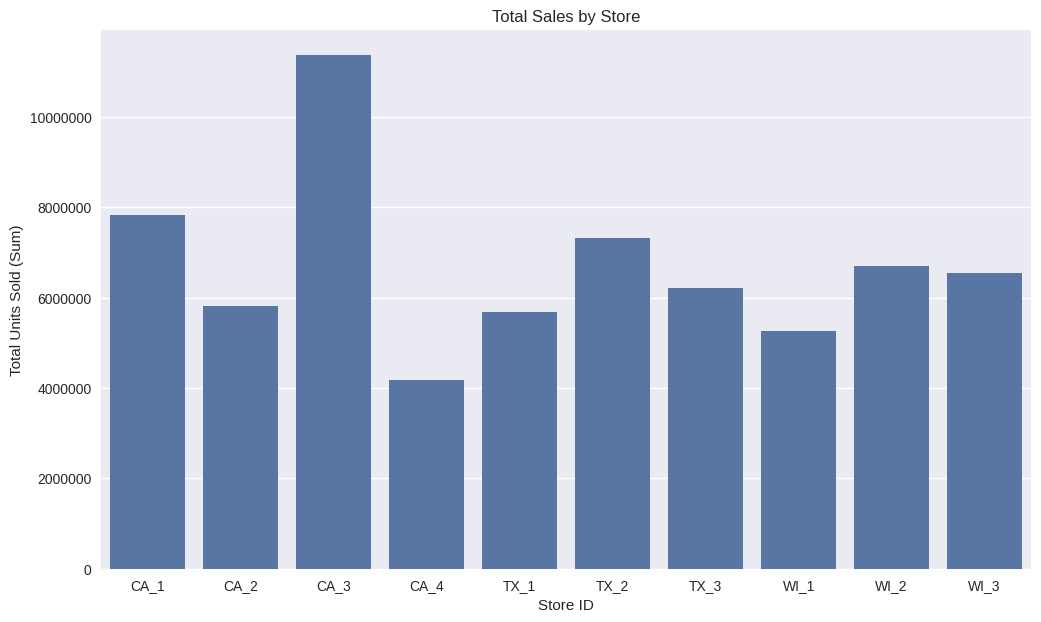

In [ ]:
plt.figure(figsize=(12, 7))

total_sales = df.groupby('store_id')['sales'].sum().reset_index()

sns.barplot(x='store_id', y='sales', data=total_sales)

plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Sales by Store')
plt.xlabel('Store ID')
plt.ylabel('Total Units Sold (Sum)')

plt.show()

del total_sales

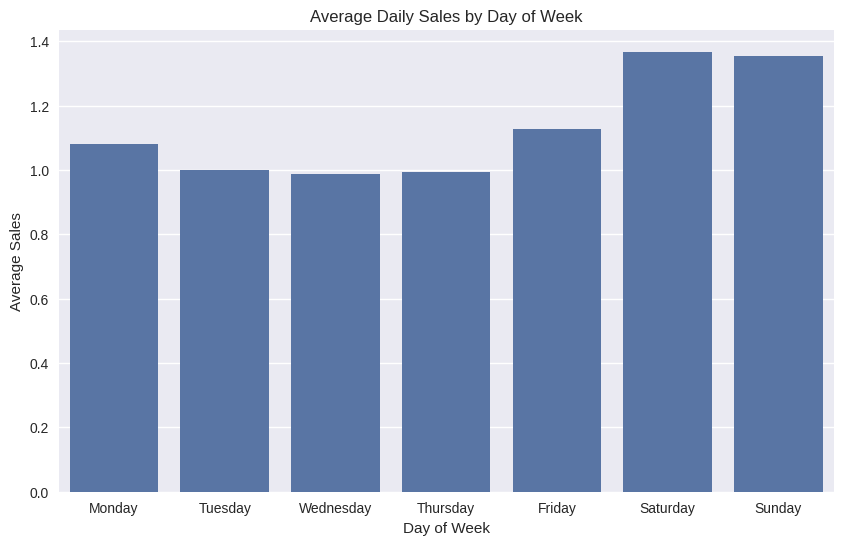

In [ ]:
# Aggregate sales by day of the week
weekday_sales = df.groupby('weekday')['sales'].mean().reset_index()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales['weekday'] = pd.Categorical(weekday_sales['weekday'], categories=weekday_order, ordered=True)
weekday_sales = weekday_sales.sort_values('weekday')

plt.figure(figsize=(10, 6))
sns.barplot(x='weekday', y='sales', data=weekday_sales)
plt.title('Average Daily Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')

plt.show()

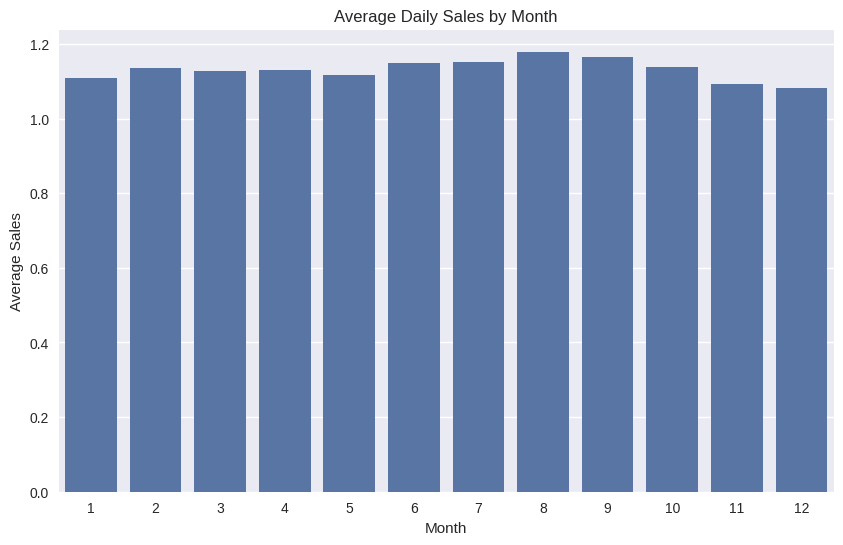

In [ ]:
month_sales = df.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='sales', data=month_sales)
plt.title('Average Daily Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')

plt.show()

del weekday_sales, weekday_order, month_sales

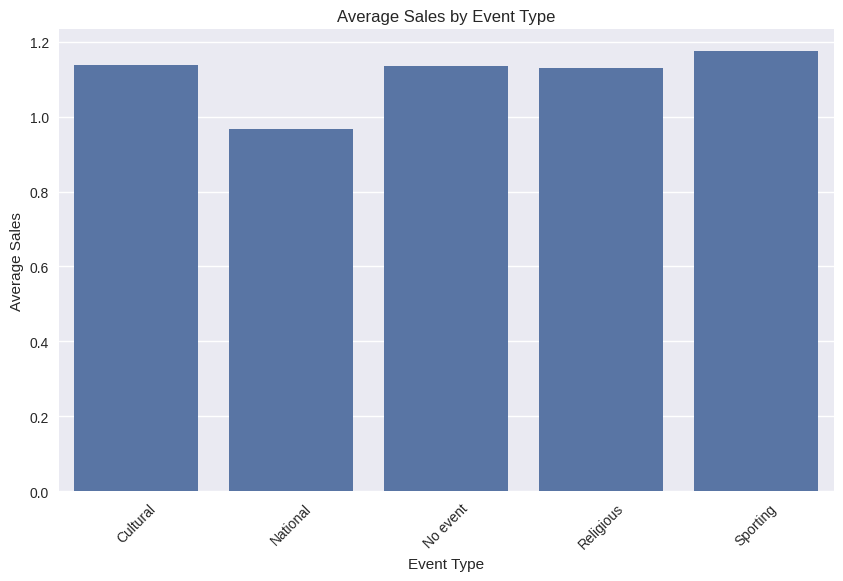

In [ ]:
# Aggregate sales by event type
event_sales = df.groupby('event_type_1')['sales'].mean().reset_index().sort_values('sales', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='event_type_1', y='sales', data=event_sales)
plt.title('Average Sales by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)

plt.show()

del event_sales